In [31]:
!pip install -q --upgrade transformers diffusers ftfy accelerate sentencepiece datasets

In [61]:
!pip install mediapy image_tools #for FiLM

In [1]:
import os, shutil
import torch

In [2]:
from stablediffusion import * #stable diffusion utils

In [3]:
from microsoftt5 import one_audio #text to audio

In [ ]:
from film_interpolation import predict #film interpolation

In [5]:
from utils import slerp



```
# This is formatted as code
```

## Get your prompts ready

In [8]:
prompts = [

    (43, "Abstract human face, happy geometric, colorful"),

    (89, "Random geometric abstract art"),

    (42, "Abstract human face, happy geometric, colorful"),

    (90, "Random geometric abstract art"),

    (19, "Abstract human face, happy geometric, colorful"),

    (67, "Random geometric abstract art"),

    (45, "Abstract human face, happy geometric, colorful"),

    (23, "Random geometric abstract art"),

    (11, "Abstract human face, happy geometric, colorful"),
]

audio_prompt = """
I've wondered.
that I've never go the hunger.
to fall asleep
only after seeing my dreams.
A mixture of miscible fluids.
wit and wisdom.
drinking the night off.
Now sleepless it remains.
"""

# Generate audio

In [7]:
length_of_video = one_audio(audio_prompt) #makes main_audio.wav file


I've wondered.
that I've never go the hunger.
to fall asleep
only after seeing my dreams.
A mixture of miscible fluids.
wit and wisdom.
drinking the night off.
Now sleepless it remains.



# Generate frames

In [ ]:
if not(os.path.exists('frames')) or not(os.path.isdir('frames')): os.makedirs('frames')

In [39]:
def generate_images_by_reading_prompts(prompts, length_of_video, target_frame_rate=24): #each in second
    """
    Here I am targeting to generate length_of_video of given frame_rate
    I am also doubling the number of images later with FILM so lets generate half the number of images
    """

    folder_path = 'frames'
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
    os.makedirs(folder_path)
    total_photos = 0
    print(prompts)

    no_of_images = length_of_video*target_frame_rate#5 extra images for bonus (sec * frames/sec)

    #As I said FILM will double it:
    no_of_images = no_of_images // 2

    num_steps = no_of_images//(len(prompts)-1)
    print("Total images to generate", no_of_images)
    print("Total video length is going to be", length_of_video)

    for i in range(len(prompts) - 1):
        print(prompts[i][1])
        cur_noise = torch.randn(
          (1, unet.in_channels, height // 8, width // 8),
          generator=torch.manual_seed(prompts[i][0]),
        )
        cur_text_embed = embed(prompts[i][1])

        next_noise = torch.randn(
          (1, unet.in_channels, height // 8, width // 8),
          generator=torch.manual_seed(prompts[i+1][0]),
        )
        next_text_embed = embed(prompts[i+1][1])

        print(num_steps)
        for j, t in enumerate(np.linspace(0, 1, num_steps)):
            print("dreaming... ", j)

            #spherical interpolation of both embeddings and images:
            cond_embedding = slerp(float(t), cur_text_embed, next_text_embed)
            init = slerp(float(t), cur_noise, next_noise)

            diffused_latents = diffuse(cond_embedding, init)

            latents = diffused_latents
            #decode the formed latent into an image
            image = decode_latent(latents)

            #save image
            outpath = os.path.join("./frames", 'frame%06d.jpg' % total_photos)
            image.save(outpath)
            total_photos += 1
    print(f"Generated {total_photos}")

/content/stablediffusion.py:113: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (1, unet.in_channels, height // 8, width // 8),
20it [00:03,  5.65it/s]
20it [00:03,  5.61it/s]
20it [00:03,  5.50it/s]
20it [00:03,  5.39it/s]
20it [00:03,  5.47it/s]
20it [00:03,  5.50it/s]
20it [00:03,  5.62it/s]
20it [00:03,  5.72it/s]
20it [00:03,  5.77it/s]


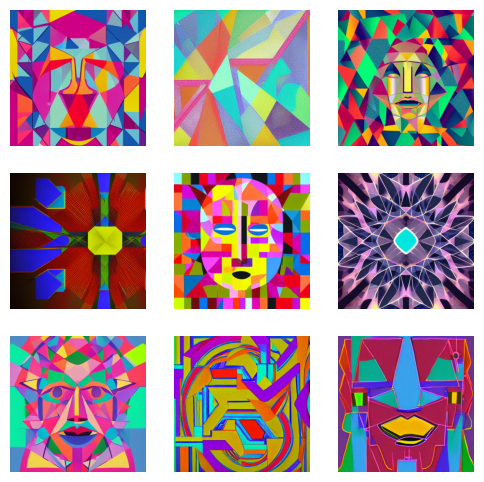

In [48]:
test_the_prompts(prompts)

In [ ]:
generate_images_by_reading_prompts(prompts, length_of_video=int(length_of_video//1000), target_frame_rate=24)
#go get some coffee; creates frames

# Film interpolation

In [9]:
#film:
total_number_of_frames = predict(1) #generates main_video.mp4

100%|█████████████████████████████████████████████████████████████| 143/143 [01:28<00:00,  1.61it/s]


Total number of frames after interpolation is 287


# Combine video and audio

In [ ]:
# combine video and audio
from moviepy.editor import VideoFileClip, AudioFileClip

video_clip = VideoFileClip('main_video.mp4')
audio_clip = AudioFileClip('main_audio.wav')
final_clip = video_clip.set_audio(audio_clip)
final_clip.write_videofile('combined.mp4') #combines main_video.mpt and main_audio.mp4